In [1]:
from env import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from itertools import combinations
from datetime import datetime

from IPython.display import Markdown


In [8]:
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

url = f'mysql+pymysql://{user}:{password}@{host}/curriculum_logs'
query = '''
select *
from api_access;
'''
df = pd.read_sql(query, url)
df = df.entry.apply(parse_log_entry)
df['timestamp'] = pd.to_datetime(df.timestamp)

# Bin all times into their respective hours
df['hour'] = df.timestamp.dt.strftime('%H')
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent,hour
0,97.105.19.58,2019-04-16 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,19
1,97.105.19.58,2019-04-16 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,19
2,97.105.19.58,2019-04-16 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,19
3,97.105.19.58,2019-04-16 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,19
4,97.105.19.58,2019-04-16 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,19


In [3]:
def value_counts_and_frequencies(s: pd.Series, dropna=True) -> pd.DataFrame:
    return pd.merge(
        s.value_counts(dropna=False).rename('count'),
        s.value_counts(dropna=False, normalize=True).rename('proba'),
        left_index=True,
        right_index=True,
    )

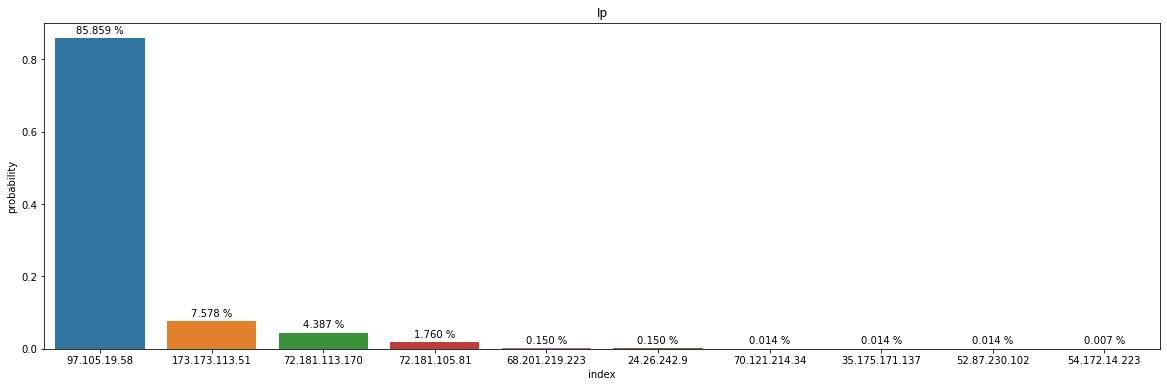

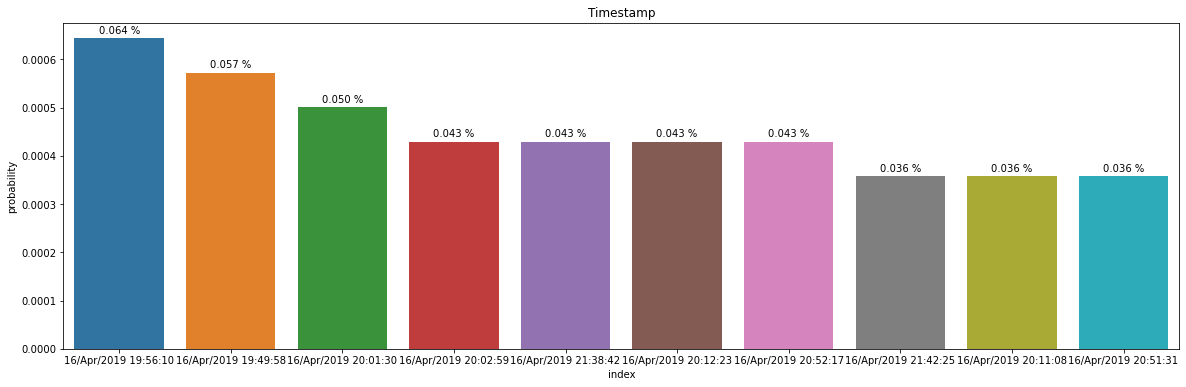

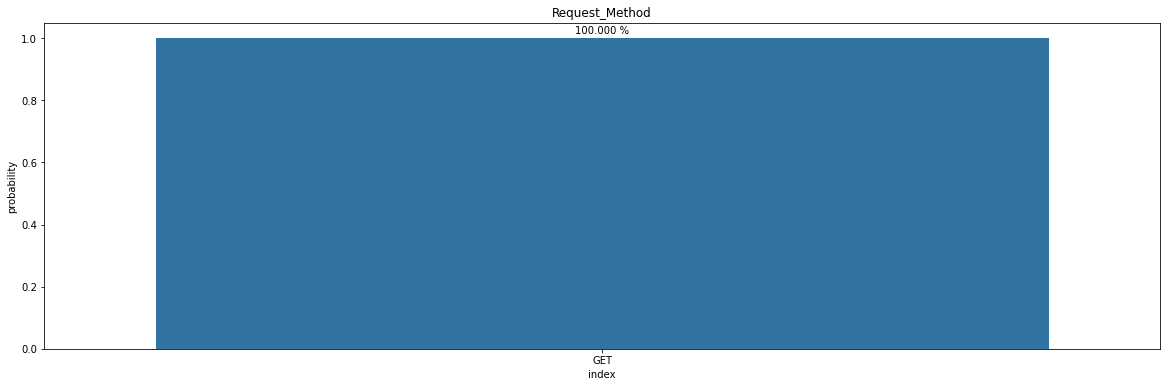

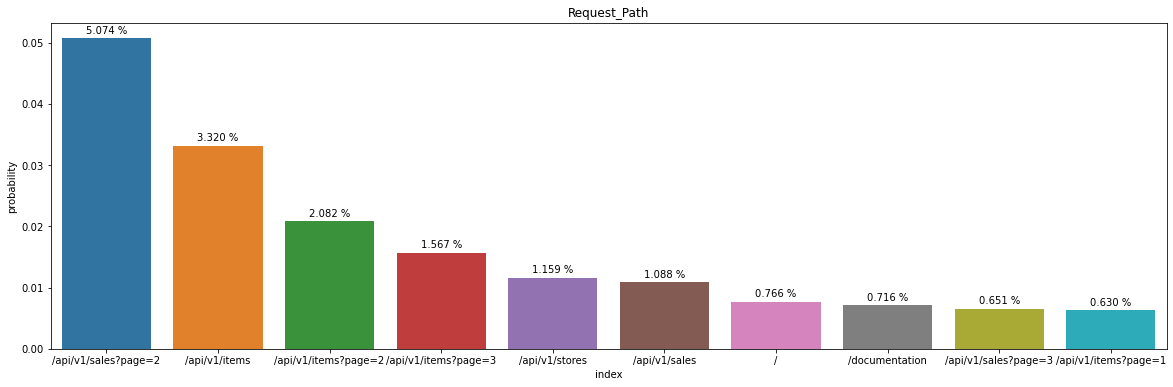

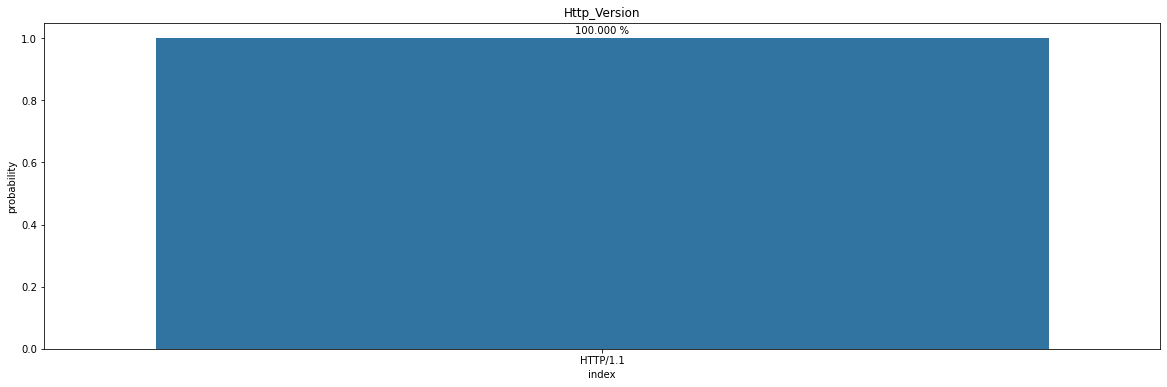

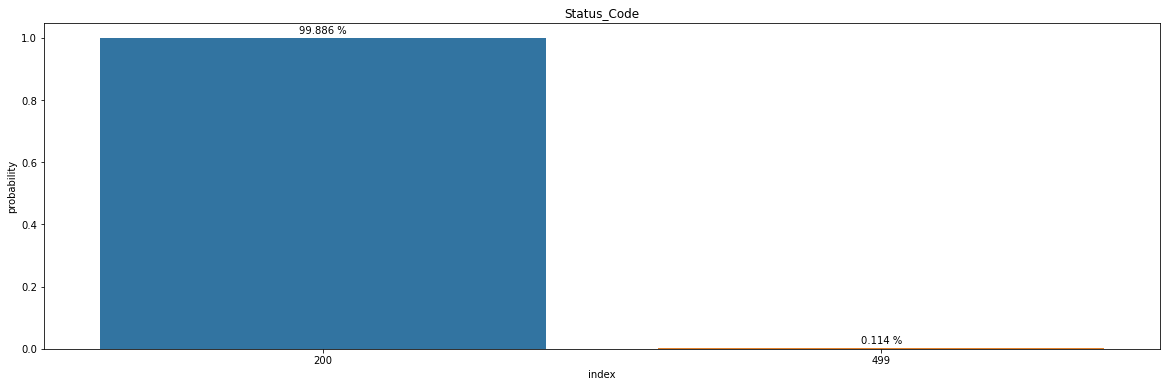

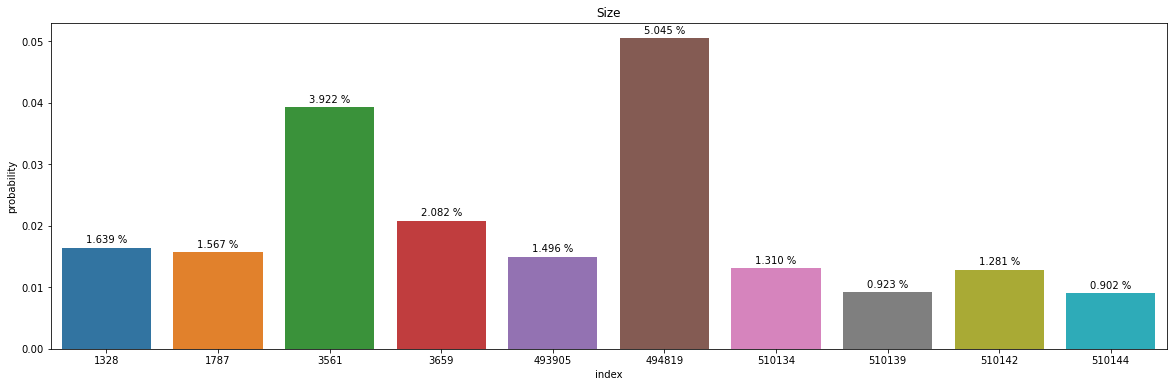

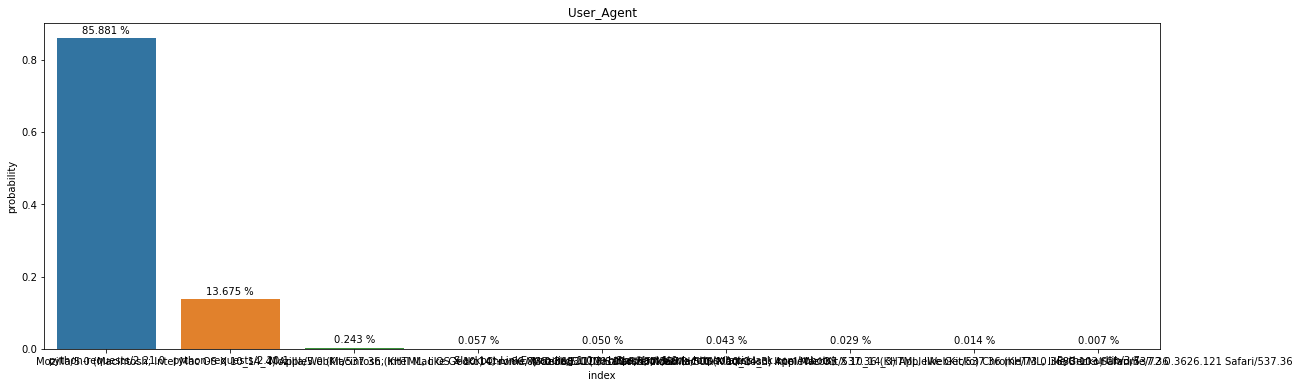

In [4]:
for col in df.columns:
    plt.figure(figsize=(20, 6))
    splot = sns.barplot(x='index', y=col, data=df[col].value_counts(normalize=True).reset_index().sort_values(
        by=col, ascending=False).head(10))
    for p in splot.patches:
        splot.annotate(format(p.get_height() * 100, '.3f') + ' %', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10,
                   xytext = (0, 8), 
                   textcoords = 'offset points')
    plt.title(col.title())
    plt.ylabel('probability')
    plt.show()

In [9]:
# Avoids any datetime columns
columns = [col for col in df.columns if not np.issubdtype(df[col], np.datetime64)]
# Creates all unique combinations for all columns
combs = set(list(combinations(columns, 2)))

# Anomaly Threshhold
threshhold = .001

result = f'### Anomaly DataFrames for Threshhold of {threshhold}\n\n'

# List of DataFrames which were lower than the anomaly threshhold
lst_of_anomalies = list()

for comb in combs:
    d1 = comb[0]
    d2 = comb[1]
    new_colname = f'proba_{d1}_given_{d2}'
    tmp_df = pd.DataFrame(df.groupby(d1)[d2].value_counts(normalize=True).rename(new_colname).reset_index())
    # Add to the results Markdown Creation 
    result += f'#### {d1.title()} given {d2.title()}\n\n'
    
    # Add the dataframe to the Markdown to view
    result += tmp_df[tmp_df[new_colname] < threshhold].to_markdown() + '\n\n'
    
    # Add to the lst_of_anomalies to view later if desired
    lst_of_anomalies.append(tmp_df[tmp_df[new_colname] < threshhold])
    

Markdown(result)

### Anomaly DataFrames for Threshhold of 0.001

#### Request_Method given Status_Code

| request_method   | status_code   | proba_request_method_given_status_code   |
|------------------|---------------|------------------------------------------|

#### Http_Version given User_Agent

|    | http_version   | user_agent                                                                                                                |   proba_http_version_given_user_agent |
|---:|:---------------|:--------------------------------------------------------------------------------------------------------------------------|--------------------------------------:|
|  3 | HTTP/1.1       | Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0                                        |                           0.000572492 |
|  4 | HTTP/1.1       | Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots)                                                                |                           0.00050093  |
|  5 | HTTP/1.1       | Slackbot 1.0 (+https://api.slack.com/robots)                                                                              |                           0.000429369 |
|  6 | HTTP/1.1       | Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36 |                           0.000286246 |
|  7 | HTTP/1.1       | Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/72.0.3626.121 Safari/537.36 |                           0.000143123 |
|  8 | HTTP/1.1       | Python-urllib/3.7                                                                                                         |                           7.15615e-05 |

#### Request_Path given Size

| request_path   | size   | proba_request_path_given_size   |
|----------------|--------|---------------------------------|

#### Status_Code given Hour

|    |   status_code |   hour |   proba_status_code_given_hour |
|---:|--------------:|-------:|-------------------------------:|
| 11 |           200 |     00 |                    0.000573148 |
| 12 |           200 |     23 |                    0.000143287 |
| 13 |           200 |     10 |                    7.16435e-05 |

#### Request_Method given Hour

|    | request_method   |   hour |   proba_request_method_given_hour |
|---:|:-----------------|-------:|----------------------------------:|
| 11 | GET              |     00 |                       0.000572492 |
| 12 | GET              |     23 |                       0.000143123 |
| 13 | GET              |     10 |                       7.15615e-05 |

#### Status_Code given User_Agent

|    |   status_code | user_agent                                                                                                                |   proba_status_code_given_user_agent |
|---:|--------------:|:--------------------------------------------------------------------------------------------------------------------------|-------------------------------------:|
|  3 |           200 | Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0                                        |                          0.000573148 |
|  4 |           200 | Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots)                                                                |                          0.000501505 |
|  5 |           200 | Slackbot 1.0 (+https://api.slack.com/robots)                                                                              |                          0.000429861 |
|  6 |           200 | Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36 |                          0.000286574 |
|  7 |           200 | Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/72.0.3626.121 Safari/537.36 |                          0.000143287 |
|  8 |           200 | Python-urllib/3.7                                                                                                         |                          7.16435e-05 |

#### Request_Method given User_Agent

|    | request_method   | user_agent                                                                                                                |   proba_request_method_given_user_agent |
|---:|:-----------------|:--------------------------------------------------------------------------------------------------------------------------|----------------------------------------:|
|  3 | GET              | Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0                                        |                             0.000572492 |
|  4 | GET              | Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots)                                                                |                             0.00050093  |
|  5 | GET              | Slackbot 1.0 (+https://api.slack.com/robots)                                                                              |                             0.000429369 |
|  6 | GET              | Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36 |                             0.000286246 |
|  7 | GET              | Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/72.0.3626.121 Safari/537.36 |                             0.000143123 |
|  8 | GET              | Python-urllib/3.7                                                                                                         |                             7.15615e-05 |

#### Size given Hour

| size   | hour   | proba_size_given_hour   |
|--------|--------|-------------------------|

#### Size given User_Agent

| size   | user_agent   | proba_size_given_user_agent   |
|--------|--------------|-------------------------------|

#### Ip given Size

|     | ip             |   size |   proba_ip_given_size |
|----:|:---------------|-------:|----------------------:|
| 175 | 173.173.113.51 |     42 |           0.000944287 |
| 176 | 173.173.113.51 |    348 |           0.000944287 |
| 177 | 173.173.113.51 | 409449 |           0.000944287 |
| 738 | 97.105.19.58   | 130921 |           0.000250042 |
| 739 | 97.105.19.58   |     48 |           0.000166694 |
| 740 | 97.105.19.58   |    126 |           8.33472e-05 |
| 741 | 97.105.19.58   | 278377 |           8.33472e-05 |
| 742 | 97.105.19.58   | 327529 |           8.33472e-05 |
| 743 | 97.105.19.58   | 343913 |           8.33472e-05 |
| 744 | 97.105.19.58   | 360297 |           8.33472e-05 |

#### Ip given Request_Path

|     | ip             | request_path                            |   proba_ip_given_request_path |
|----:|:---------------|:----------------------------------------|------------------------------:|
| 187 | 173.173.113.51 | /                                       |                   0.000944287 |
| 188 | 173.173.113.51 | /documentation                          |                   0.000944287 |
| 793 | 97.105.19.58   | /api/v1//api/v1/items?page=2            |                   0.000833472 |
| 794 | 97.105.19.58   | /api/v1/items/api/v1/items?page=2       |                   0.000416736 |
| 795 | 97.105.19.58   | /api/v1/items/next_page                 |                   0.000416736 |
| 796 | 97.105.19.58   | /api/v1/stores?page=3                   |                   0.000333389 |
| 797 | 97.105.19.58   | /api/v1/itemsitems                      |                   0.000250042 |
| 798 | 97.105.19.58   | /api/v1/sales/?page=2                   |                   0.000250042 |
| 799 | 97.105.19.58   | /api/v1/store                           |                   0.000250042 |
| 800 | 97.105.19.58   | /api/v1/stores?page=0                   |                   0.000166694 |
| 801 | 97.105.19.58   | /api/v1/stores?page=183                 |                   0.000166694 |
| 802 | 97.105.19.58   | /api/V1/HiZach!                         |                   8.33472e-05 |
| 803 | 97.105.19.58   | /api/v1                                 |                   8.33472e-05 |
| 804 | 97.105.19.58   | /api/v1/                                |                   8.33472e-05 |
| 805 | 97.105.19.58   | /api/v1//api/v1/items                   |                   8.33472e-05 |
| 806 | 97.105.19.58   | /api/v1//api/v1/items/next_page         |                   8.33472e-05 |
| 807 | 97.105.19.58   | /api/v1/I_DIDNT_DO_IT!!!!               |                   8.33472e-05 |
| 808 | 97.105.19.58   | /api/v1/helloclass!                     |                   8.33472e-05 |
| 809 | 97.105.19.58   | /api/v1/items&page=0                    |                   8.33472e-05 |
| 810 | 97.105.19.58   | /api/v1/items?page=0                    |                   8.33472e-05 |
| 811 | 97.105.19.58   | /api/v1/items?page=99999999999999999998 |                   8.33472e-05 |
| 812 | 97.105.19.58   | /api/v1/stores?page=2                   |                   8.33472e-05 |
| 813 | 97.105.19.58   | /api/v1/stores?page=666                 |                   8.33472e-05 |
| 814 | 97.105.19.58   | /api/v1/stores?page=999                 |                   8.33472e-05 |
| 815 | 97.105.19.58   | /api/v1items                            |                   8.33472e-05 |

#### Request_Method given Http_Version

| request_method   | http_version   | proba_request_method_given_http_version   |
|------------------|----------------|-------------------------------------------|

#### Request_Path given Status_Code

| request_path   | status_code   | proba_request_path_given_status_code   |
|----------------|---------------|----------------------------------------|

#### Request_Path given Hour

| request_path   | hour   | proba_request_path_given_hour   |
|----------------|--------|---------------------------------|

#### Request_Path given User_Agent

| request_path   | user_agent   | proba_request_path_given_user_agent   |
|----------------|--------------|---------------------------------------|

#### Ip given Status_Code

| ip   | status_code   | proba_ip_given_status_code   |
|------|---------------|------------------------------|

#### Http_Version given Size

|     | http_version   |   size |   proba_http_version_given_size |
|----:|:---------------|-------:|--------------------------------:|
| 179 | HTTP/1.1       |     48 |                     0.000214684 |
| 180 | HTTP/1.1       | 130921 |                     0.000214684 |
| 181 | HTTP/1.1       |    126 |                     7.15615e-05 |
| 182 | HTTP/1.1       | 278377 |                     7.15615e-05 |
| 183 | HTTP/1.1       | 327529 |                     7.15615e-05 |
| 184 | HTTP/1.1       | 343913 |                     7.15615e-05 |
| 185 | HTTP/1.1       | 360297 |                     7.15615e-05 |
| 186 | HTTP/1.1       | 409449 |                     7.15615e-05 |

#### Ip given Request_Method

| ip   | request_method   | proba_ip_given_request_method   |
|------|------------------|---------------------------------|

#### Status_Code given Size

|     |   status_code |   size |   proba_status_code_given_size |
|----:|--------------:|-------:|-------------------------------:|
| 178 |           200 |     48 |                    0.000214931 |
| 179 |           200 | 130921 |                    0.000214931 |
| 180 |           200 |    126 |                    7.16435e-05 |
| 181 |           200 | 278377 |                    7.16435e-05 |
| 182 |           200 | 327529 |                    7.16435e-05 |
| 183 |           200 | 343913 |                    7.16435e-05 |
| 184 |           200 | 360297 |                    7.16435e-05 |
| 185 |           200 | 409449 |                    7.16435e-05 |

#### User_Agent given Hour

|    | user_agent             |   hour |   proba_user_agent_given_hour |
|---:|:-----------------------|-------:|------------------------------:|
| 30 | python-requests/2.21.0 |     00 |                   0.000666611 |
| 31 | python-requests/2.21.0 |     10 |                   8.33264e-05 |

#### Request_Method given Size

|     | request_method   |   size |   proba_request_method_given_size |
|----:|:-----------------|-------:|----------------------------------:|
| 179 | GET              |     48 |                       0.000214684 |
| 180 | GET              | 130921 |                       0.000214684 |
| 181 | GET              |    126 |                       7.15615e-05 |
| 182 | GET              | 278377 |                       7.15615e-05 |
| 183 | GET              | 327529 |                       7.15615e-05 |
| 184 | GET              | 343913 |                       7.15615e-05 |
| 185 | GET              | 360297 |                       7.15615e-05 |
| 186 | GET              | 409449 |                       7.15615e-05 |

#### Ip given Hour

| ip   | hour   | proba_ip_given_hour   |
|------|--------|-----------------------|

#### Ip given User_Agent

|    | ip           | user_agent                                                                                                                |   proba_ip_given_user_agent |
|---:|:-------------|:--------------------------------------------------------------------------------------------------------------------------|----------------------------:|
| 25 | 97.105.19.58 | Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36 |                 0.000166694 |
| 26 | 97.105.19.58 | Python-urllib/3.7                                                                                                         |                 8.33472e-05 |

#### Request_Method given Request_Path

|     | request_method   | request_path                            |   proba_request_method_given_request_path |
|----:|:-----------------|:----------------------------------------|------------------------------------------:|
| 193 | GET              | /api/v1//api/v1/items?page=2            |                               0.000715615 |
| 194 | GET              | /api/v1/items/api/v1/items?page=2       |                               0.000429369 |
| 195 | GET              | /api/v1/items/next_page                 |                               0.000357807 |
| 196 | GET              | /api/v1/                                |                               0.000286246 |
| 197 | GET              | /api/v1/stores?page=3                   |                               0.000286246 |
| 198 | GET              | /api/v1/itemsitems                      |                               0.000214684 |
| 199 | GET              | /api/v1/sales/?page=2                   |                               0.000214684 |
| 200 | GET              | /api/v1/store                           |                               0.000214684 |
| 201 | GET              | /api/v1/stores?page=0                   |                               0.000143123 |
| 202 | GET              | /api/v1/stores?page=183                 |                               0.000143123 |
| 203 | GET              | /api/v1items                            |                               0.000143123 |
| 204 | GET              | /api/V1/HiZach!                         |                               7.15615e-05 |
| 205 | GET              | /api/v1                                 |                               7.15615e-05 |
| 206 | GET              | /api/v1//api/v1/items                   |                               7.15615e-05 |
| 207 | GET              | /api/v1//api/v1/items/next_page         |                               7.15615e-05 |
| 208 | GET              | /api/v1/I_DIDNT_DO_IT!!!!               |                               7.15615e-05 |
| 209 | GET              | /api/v1/helloclass!                     |                               7.15615e-05 |
| 210 | GET              | /api/v1/items&page=0                    |                               7.15615e-05 |
| 211 | GET              | /api/v1/items/api/v1/items?page=3       |                               7.15615e-05 |
| 212 | GET              | /api/v1/items?page=0                    |                               7.15615e-05 |
| 213 | GET              | /api/v1/items?page=4                    |                               7.15615e-05 |
| 214 | GET              | /api/v1/items?page=99999999999999999998 |                               7.15615e-05 |
| 215 | GET              | /api/v1/stores?page=2                   |                               7.15615e-05 |
| 216 | GET              | /api/v1/stores?page=666                 |                               7.15615e-05 |
| 217 | GET              | /api/v1/stores?page=999                 |                               7.15615e-05 |

#### Request_Path given Http_Version

| request_path   | http_version   | proba_request_path_given_http_version   |
|----------------|----------------|-----------------------------------------|

#### Http_Version given Status_Code

| http_version   | status_code   | proba_http_version_given_status_code   |
|----------------|---------------|----------------------------------------|

#### Ip given Http_Version

| ip   | http_version   | proba_ip_given_http_version   |
|------|----------------|-------------------------------|

#### Http_Version given Hour

|    | http_version   |   hour |   proba_http_version_given_hour |
|---:|:---------------|-------:|--------------------------------:|
| 11 | HTTP/1.1       |     00 |                     0.000572492 |
| 12 | HTTP/1.1       |     23 |                     0.000143123 |
| 13 | HTTP/1.1       |     10 |                     7.15615e-05 |

